## Build models

Build a model to evaluation new construction vs. renovation on a data set.

(Run the "Data Normalizing" notebooks first to create a data set).

Michael Droettboom, based on work by Aron Ahmadia

The analysis requires a Python installation with scikit-learn,
pandas, and matplotlib installed for full functionality.  I highly recommend the
Anaconda distribution for fulling the dependencies.  The exact versions of
the major software used in my analysis are:

* Python 3.5.1
* Bokeh 0.10.0
* Scikit-Learn 0.17.0
* Pandas 0.17.1
* Jupyter 1.0.0 (meta-package for Jupyter 4)
* Matplotlib 1.5.0

In [20]:
%matplotlib inline

In [21]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error

In [22]:
# load TSV into pandas as DataFrame

df = pd.read_csv('missouri-normal.csv') 
# or
# df = pd.read_csv('seattle.csv')

In [23]:
# Subsample to get about 15000 entries
df = df[::int(len(df)/15000)]

In [24]:
# Some basic information about the dataset
# Note that almost all the features appear to be normal distributions
# centered on 0 with standard deviation approximately 1.
# However, there is a *lot* of missing data.
# There probably isn't a need to run through a scaler, but it doesn't do any harm.

df.describe()

,Unnamed: 0,day,dwelling_units_gained_or_lost,month,permit_value,structure_class,year,target
count,15259.000000,15259.000000,15259.000000,15259.000000,15259.000000,3137.000000,15259.000000,15259
mean,132175.828429,14.238286,0.657448,6.568648,83390.830985,219.719796,1988.042074,0.310833
std,55130.689365,9.401285,3.163857,3.222907,576445.297343,192.063475,11.166400,0.46285
min,38602.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1970.000000,False
25%,80561.500000,6.000000,0.000000,4.000000,1100.000000,97.000000,1978.000000,0
50%,138601.000000,14.000000,0.000000,7.000000,10000.000000,101.000000,1988.000000,0
75%,180560.500000,22.000000,1.000000,9.000000,58561.500000,434.000000,1998.000000,1
max,222520.000000,31.000000,163.000000,12.000000,34823025.000000,649.000000,2007.000000,True


In [25]:
del df['Unnamed: 0']
df.columns

Index(['day', 'dwelling_units_gained_or_lost', 'month', 'permit_value',
       'res_non', 'sf_mf', 'structure_class', 'year', 'type', 'target'],
      dtype='object')

In [26]:
for column in df.columns:
    print(column, df[column].dtype, len(pd.unique(df[column])))

day int64 32
dwelling_units_gained_or_lost int64 41
month int64 12
permit_value float64 3639
res_non object 2
sf_mf object 3
structure_class float64 27
year int64 38
type object 3
target bool 2


In [27]:
# The 'target' column contains new construction vs. renovation, which is the target of the model

target = df['target']
del df['target']

if 'type' in df.columns:
    del df['type']

In [28]:
dfd = pd.get_dummies(df)

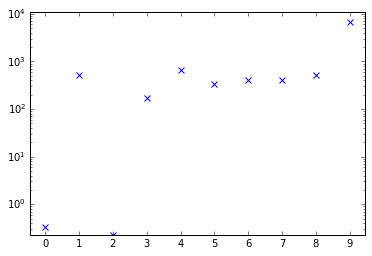

In [29]:
# Evaluate feasibility of extracting a subset of important features
# Looks like a good candidate for k-best feature selection

dfi = Imputer().fit_transform(dfd)
f, p = f_regression(dfi, target)
plt.plot(f, 'bx')
plt.gca().set_yscale('log')

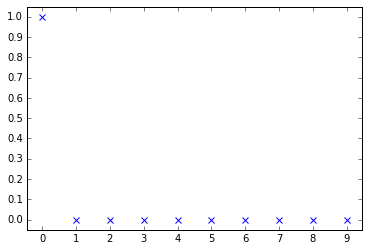

In [30]:
# Evaluate feasibility of extracting a subset of important components
# Energy seems to be pretty evenly distributed among principal components
# Not a good candidate for extracting principal components

pca = PCA()
pca.fit(dfi)
plt.plot(pca.explained_variance_ratio_, 'bx')

In [31]:
# We can now conduct a grid search over the hyperparameters of several models to
# choose a tuned model

imputer = Imputer(strategy=None)
scaler = StandardScaler()
kbest = SelectKBest(f_regression, k=None)
rfr = RandomForestRegressor(n_estimators=None)

In [32]:
# Helper function to tune the pipeline and print out the tuned parameters

def tune_pipeline(fullname, shortname, model, params):
    pipeline = Pipeline([('imputer', imputer), ('scaler', scaler), ('kbest', kbest), (shortname, model)])
    grid_search = GridSearchCV(pipeline, param_grid=params, scoring='mean_squared_error')
    grid_search.fit(dfd, target)
    print("Results for {}".format(fullname))
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return grid_search

In [33]:
# start with a simple random forest as we try to determine the ideal imputer and number of features to select.
# Let's try to pick an imputer strategy first.

# Note that I hand-picked a few seed values here based on eyeballing earlier plots.

tuned = tune_pipeline('Random Forest Regressor', 'rfr', rfr,
                      params = dict(imputer__strategy=['mean', 'median', 'most_frequent'],
                                    kbest__k=[9],
                                    rfr__n_estimators=[9]))

Results for Random Forest Regressor
{'rfr__n_estimators': 9, 'imputer__strategy': 'mean', 'kbest__k': 9}
-0.0511865959193


In [34]:
# Okay, now let's try to determine the right number of features to select.  
# We know approximately how many we want from the f_regression scores

tuned = tune_pipeline('Random Forest Regressor', 'rfr', rfr,
                      params = dict(imputer__strategy=[tuned.best_params_['imputer__strategy']],
                                    kbest__k=[1, 2, 3, 4, 5, 6, 7, 8, 9],
                                    rfr__n_estimators=[9]))

Results for Random Forest Regressor
{'rfr__n_estimators': 9, 'imputer__strategy': 'mean', 'kbest__k': 9}
-0.0519398657528


In [35]:
# Final comparison, learning curves for SVR and a more aggressive RFR
# This function is adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, X, y, title="Learning Curve", ylim=None, cv=None, n_jobs=1):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    title : string
        Title for the chart.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default -1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

In [36]:
imputer_prod = Imputer(strategy=tuned.best_params_['imputer__strategy'])
scaler_prod = StandardScaler()
kbest_prod = SelectKBest(f_regression, tuned.best_params_['kbest__k'])
rfr_prod = RandomForestRegressor(n_estimators=100)
svc_prod = LinearSVC()
svcr_prod = SVC(kernel='rbf')

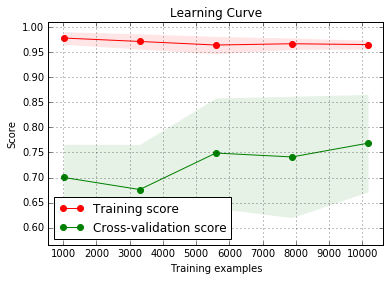

In [37]:
prod_rfr = Pipeline([('imputer', imputer_prod), ('scaler', scaler_prod), 
                          ('kbest', kbest_prod), ('rfr', rfr_prod)])
plot_learning_curve(prod_rfr, dfd, target)

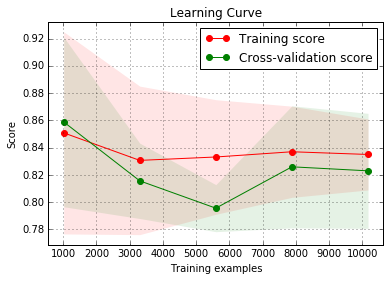

In [38]:
prod_svc = Pipeline([('imputer', imputer_prod), ('scaler', scaler_prod), 
                          ('kbest', kbest_prod), ('svc', svc_prod)])
plot_learning_curve(prod_svc, dfd, target)

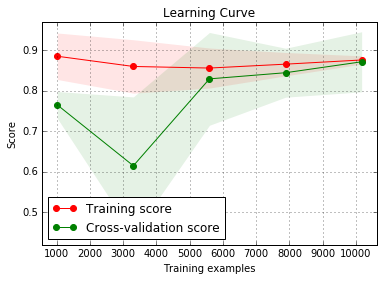

In [39]:
prod_svcr = Pipeline([('imputer', imputer_prod), ('scaler', scaler_prod), 
                          ('kbest', kbest_prod), ('svcr', svcr_prod)])
plot_learning_curve(prod_svcr, dfd, target)

In [40]:
# without increasing C, the MSE of the cross-validated fit to the training data is around 4

cross_val_score(prod_svc, dfd, target)

array([ 0.76410458,  0.85843492,  0.84368856])

In [41]:
# This is the best pipeline we've found, 
# * median or mean imputer (this makes sense, the median/mean of a normal distribution are the same), 
# * standard scaler, 
# * threshold to the 16 best features
# * Support Vector Regression using a radial-basis function and C=10

prod_svc.fit(dfd, target)

Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=9, score_func=<function f_regression at 0x7f302d4a0400>)), ('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [42]:
# Let's review the best components

selected_features = prod_svc.named_steps['kbest'].get_support()
print(dfd.columns[selected_features])

Index(['day', 'dwelling_units_gained_or_lost', 'permit_value',
       'structure_class', 'year', 'res_non_Non-Residential',
       'res_non_Residential', 'sf_mf_Multifamily', 'sf_mf_Single Family'],
      dtype='object')


In [43]:
# The best pipeline fits its training data with an MSE of 1.33
# Assuming that the withheld data is a non-pathological sample,
# the MSE of the fit to the withheld data should be between 3.2 and 1.33

mean_squared_error(target, prod_svc.predict(dfd))

/home/mdboom/.pyenv/versions/miniconda3-3.16.0/lib/python3.4/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


0.16626253358673571

In [45]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].

# create a mesh to plot in
x_min, x_max = dfd['year'].min() - 1, dfd['year'].max() + 1
y_min, y_max = dfd['permit_value'].min() - 1, dfd['permit_value'].max() + 1
print(x_min, x_max)
print(y_min, y_max)

1969 2008
-1.0 34823026.0


In [59]:
svc_prod = LinearSVC()
svc_prod.fit(dfd[["permit_value", "year"]], target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

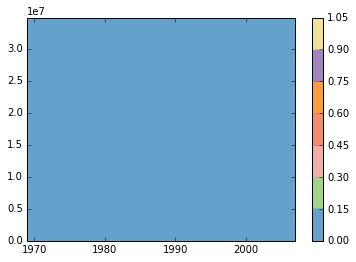

In [60]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 50))

Z = svc_prod.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.colorbar()

In [53]:
plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).